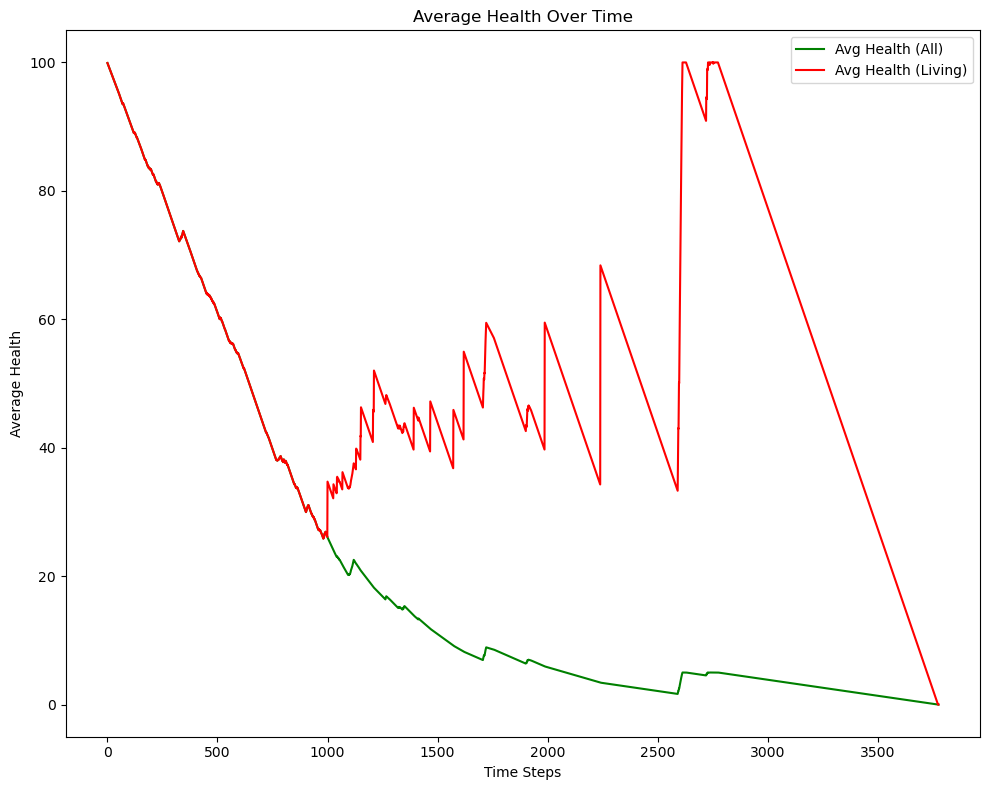

In [4]:
import pygame
import random
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Constants (unchanged)
WIDTH, HEIGHT = 800, 600
SUGAR_RADIUS = 20
ANT_SIZE = 10
ANT_SPEED = 2
NUM_ANTS = 20
SUGAR_MAX = 100
SUGAR_REGENERATION_RATE = 0.1
SQUARE_SIZE = 5
REGENERATION_INTERVAL = 1000
ANT_HEALTH = 100
HEALTH_INCREASE = 10
HEALTH_DECREASE_RATE = 0.1
SPICE_RADIUS = 15
SPICE_MAX = 50
SPICE_REGENERATION_RATE = 0.05
SPICE_SIZE = 10

# Color definitions (unchanged)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)

# Initialize font
pygame.font.init()
FONT = pygame.font.Font(None, 36)

def get_ant_color(health):
    """
    Determine the color of an ant based on its health.
    As health decreases, the ant fades to white.
    """
    intensity = int((health / ANT_HEALTH) * 255)
    return (255, 255, 255 - intensity)

class Ant:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.health = 100
        self.direction = random.uniform(0, 2 * math.pi)
        self.turn_angle = math.pi / 8
        self.avoid_distance = 20
        self.sugar = 0
        self.spice = 0
        
        # Attributes for comparative advantage
        self.sugar_mining_skill = random.uniform(0.5, 1.5)
        self.spice_mining_skill = random.uniform(0.5, 1.5)
        self.sugar_preference = 2 - self.sugar_mining_skill  # Inverse relationship
        self.spice_preference = 2 - self.spice_mining_skill  # Inverse relationship

    def detect_nearby_ants(self, ants):
        for other_ant in ants:
            if other_ant != self:
                dx = other_ant.x - self.x
                dy = other_ant.y - self.y
                distance = math.sqrt(dx ** 2 + dy ** 2)
                if distance < self.avoid_distance:
                    self.direction += math.pi
                    return

    def move(self, ants):
        self.detect_nearby_ants(ants)
        self.direction += random.uniform(-self.turn_angle, self.turn_angle)
        self.x += ANT_SPEED * math.cos(self.direction)
        self.y += ANT_SPEED * math.sin(self.direction)
        self.x = max(0, min(self.x, WIDTH))
        self.y = max(0, min(self.y, HEIGHT))

    def mine_resource(self, resource_type):
        if resource_type == 'sugar':
            mined_amount = random.uniform(0.5, 1.0) * self.sugar_mining_skill
            self.sugar += mined_amount
        elif resource_type == 'spice':
            mined_amount = random.uniform(0.5, 1.0) * self.spice_mining_skill
            self.spice += mined_amount
        return mined_amount

    def consume_resources(self):
        sugar_consumed = min(self.sugar, self.sugar_preference)
        spice_consumed = min(self.spice, self.spice_preference)
        
        self.sugar -= sugar_consumed
        self.spice -= spice_consumed
        
        total_consumed = sugar_consumed + spice_consumed
        health_increase = HEALTH_INCREASE * (total_consumed / (self.sugar_preference + self.spice_preference))
        
        self.health += health_increase
        self.health = min(self.health, ANT_HEALTH)

    def decrease_health(self):
        self.health -= HEALTH_DECREASE_RATE
        self.health = max(0, self.health)

    def act(self, sugarscape):
        if self.health <= 0:
            return

        self.decrease_health()
        self.move(sugarscape.ants)
        
        for sugar in sugarscape.sugar_patches:
            if sugar[2]:
                dx = sugar[0] - self.x
                dy = sugar[1] - self.y
                dist = math.sqrt(dx ** 2 + dy ** 2)
                if dist < SUGAR_RADIUS:
                    sugar[2] = False
                    sugar[3] -= 1
                    sugarscape.consumed_sugar_patches.append(sugar)
                    mined_amount = self.mine_resource('sugar')
                    sugarscape.sugar_mined += mined_amount
                    break
        
        for spice in sugarscape.spice_patches:
            if spice[2]:
                dx = spice[0] - self.x
                dy = spice[1] - self.y
                dist = math.sqrt(dx ** 2 + dy ** 2)
                if dist < SPICE_RADIUS:
                    spice[2] = False
                    spice[3] -= 1
                    sugarscape.consumed_spice_patches.append(spice)
                    mined_amount = self.mine_resource('spice')
                    sugarscape.spice_mined += mined_amount
                    break

        self.consume_resources()

class SugarScape:
    def __init__(self):
        self.sugar_spots = [(200, 300), (600, 300)]
        self.spice_spots = [(400, 100), (400, 500)]
        self.ants = [Ant(random.randint(0, WIDTH), random.randint(0, HEIGHT)) for _ in range(NUM_ANTS)]
        self.dead_ants = []
        self.sugar_patches = self.initialize_sugar_patches()
        self.spice_patches = self.initialize_spice_patches()
        self.consumed_sugar_patches = []
        self.consumed_spice_patches = []
        self.last_regeneration_time = pygame.time.get_ticks()
        self.sugar_mined = 0
        self.spice_mined = 0
        self.health_all = []
        self.health_living = []
        self.metrics = {
            "Avg Health (All)": 0,
            "Avg Health (Living)": 0,
            "Sugar Available": len(self.sugar_patches),
            "Spice Available": len(self.spice_patches),
            "Living Ants": NUM_ANTS,
            "Sugar Mined": 0,
            "Spice Mined": 0
        }

    def initialize_sugar_patches(self):
        patches = []
        for (x, y) in self.sugar_spots:
            for n in range(SUGAR_MAX):
                square_x = x + (n % 10) * SQUARE_SIZE - 5 * SQUARE_SIZE
                square_y = y + (n // 10) * SQUARE_SIZE - 5 * SQUARE_SIZE
                patches.append([square_x, square_y, True, SQUARE_SIZE])
        return patches

    def initialize_spice_patches(self):
        patches = []
        for (x, y) in self.spice_spots:
            for n in range(SPICE_MAX):
                square_x = x + (n % 10) * SPICE_SIZE - 5 * SPICE_SIZE
                square_y = y + (n // 10) * SPICE_SIZE - 5 * SPICE_SIZE
                patches.append([square_x, square_y, True, SPICE_SIZE])
        return patches

    def update(self):
        for ant in self.ants[:]:
            if ant.health > 0:
                ant.act(self)
            else:
                self.dead_ants.append(ant)
                self.ants.remove(ant)

        # Calculate and update metrics
        all_healths = [ant.health for ant in self.ants] + [0 for _ in self.dead_ants]
        living_healths = [ant.health for ant in self.ants if ant.health > 0]
        
        self.metrics["Avg Health (All)"] = sum(all_healths) / len(all_healths) if all_healths else 0
        self.metrics["Avg Health (Living)"] = sum(living_healths) / len(living_healths) if living_healths else 0
        self.metrics["Sugar Available"] = len([s for s in self.sugar_patches if s[2]])
        self.metrics["Spice Available"] = len([s for s in self.spice_patches if s[2]])
        self.metrics["Living Ants"] = len(self.ants)
        self.metrics["Sugar Mined"] = self.sugar_mined
        self.metrics["Spice Mined"] = self.spice_mined
        
        self.health_all.append(self.metrics["Avg Health (All)"])
        self.health_living.append(self.metrics["Avg Health (Living)"])
        
        self.regenerate_resources()

    def regenerate_resources(self):
        current_time = pygame.time.get_ticks()
        if current_time - self.last_regeneration_time > REGENERATION_INTERVAL:
            # Regenerate sugar
            for sugar in self.sugar_patches:
                if not sugar[2]:  # If the sugar patch is consumed
                    if random.random() < SUGAR_REGENERATION_RATE:
                        sugar[2] = True  # Respawn the sugar
                        if sugar in self.consumed_sugar_patches:
                            self.consumed_sugar_patches.remove(sugar)
            
            # Regenerate spice
            for spice in self.spice_patches:
                if not spice[2]:  # If the spice patch is consumed
                    if random.random() < SPICE_REGENERATION_RATE:
                        spice[2] = True  # Respawn the spice
                        if spice in self.consumed_spice_patches:
                            self.consumed_spice_patches.remove(spice)
            
            self.last_regeneration_time = current_time

# The main function and drawing functions remain unchanged

def plot_health( health_all, health_living):
    fig, ax2 = plt.subplots(figsize=(10, 8))

    # Plot average healths
    ax2.plot(health_all, color='green', label='Avg Health (All)')
    ax2.plot(health_living, color='red', label='Avg Health (Living)')
    ax2.set_title('Average Health Over Time')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Average Health')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def draw_metrics(surface, metrics):
    y_offset = 10
    for metric, value in metrics.items():
        text = FONT.render(f"{metric}: {int(value)}" if isinstance(value, float) else f"{metric}: {value}", True, BLACK)
        surface.blit(text, (10, y_offset))
        y_offset += 30

def draw_sugarscape(surface, sugarscape):
    surface.fill(WHITE)
    for ant in sugarscape.ants:
        pygame.draw.circle(surface, get_ant_color(ant.health), (int(ant.x), int(ant.y)), ANT_SIZE)
    for sugar in sugarscape.sugar_patches:
        if sugar[2]:
            pygame.draw.rect(surface, GREEN, pygame.Rect(sugar[0], sugar[1], sugar[3], sugar[3]))
    for spice in sugarscape.spice_patches:
        if spice[2]:
            pygame.draw.rect(surface, RED, pygame.Rect(spice[0], spice[1], SPICE_SIZE, SPICE_SIZE))


    draw_metrics(surface, sugarscape.metrics)
    pygame.display.flip()

def main():
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    sugarscape = SugarScape()
    clock = pygame.time.Clock()
    running = True

    while running and len(sugarscape.ants) > 0:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        sugarscape.update()
        draw_sugarscape(screen, sugarscape)
        clock.tick(60)

    pygame.quit()

    # Plot cumulative trades and average health
    plot_health(sugarscape.health_all, sugarscape.health_living)

if __name__ == "__main__":
    main()